<a href="https://colab.research.google.com/github/Lalasa1234/WaterBody_SemanticSegmentation/blob/main/PyTorchModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import torch
from torchvision.transforms import v2
import glob
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import numpy as np
from numpy import asarray

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm

SIZE = 128
SEED = 42
BATCH = 32
EPOCHS = 10

In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount =True)

Mounted at /content/drive


In [7]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation'

In [8]:
real_data = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Images/' + '*.jpg'))
masked_data = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/' + '*.jpg'))

In [9]:
print ('Real Data - ', Image.open(real_data[2]).mode)
print (asarray(Image.open(real_data[2])).shape, np.transpose(Image.open(real_data[2]),(2,0,1)).shape)
# Masked data looks grayscaled. hence this needs to be changed
test_mask = Image.open(masked_data[2])
print ('Masked Data - ', test_mask.getbands(), asarray(test_mask.convert('L')).shape, np.expand_dims(asarray(test_mask.convert('L')), 0).shape)
print ('Min and max of real data is ',asarray(Image.open(real_data[2])).min(),asarray(Image.open(real_data[2])).max())
print ('Min and max is mask data is ',asarray(test_mask).min(),asarray(test_mask).max())

Real Data -  RGB
(565, 568, 3) (3, 565, 568)
Masked Data -  ('R', 'G', 'B') (565, 568) (1, 565, 568)
Min and max of real data is  0 196
Min and max is mask data is  0 255


### Display real and masked of some images side by side

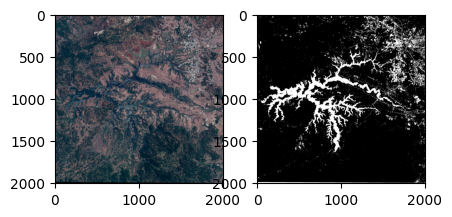

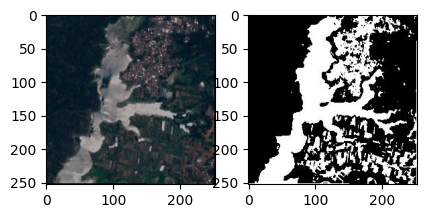

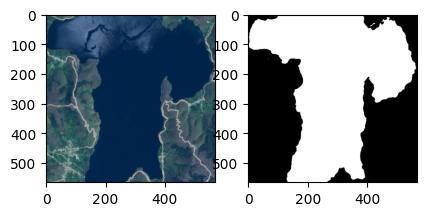

In [10]:
for i in range(3):
  plt.figure(figsize=(10,10))
  plt.subplot(341 + i)
  plt.imshow(Image.open(real_data[i]))
  plt.subplot(342 + i)
  plt.imshow(Image.open(masked_data[i]))

### Check the resize function by observing the axes

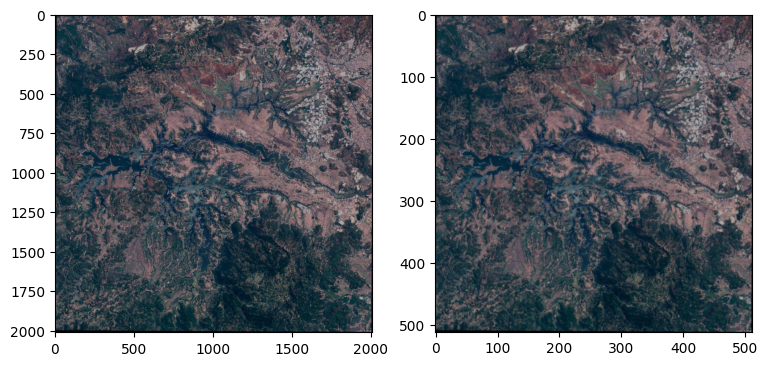

In [11]:
resizer = v2.Resize((512, 512))
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(Image.open(real_data[0]))
plt.subplot(1,2,2)
plt.imshow(resizer(Image.open(real_data[0])))

### Testing the Random Horizontal Flip on the same image

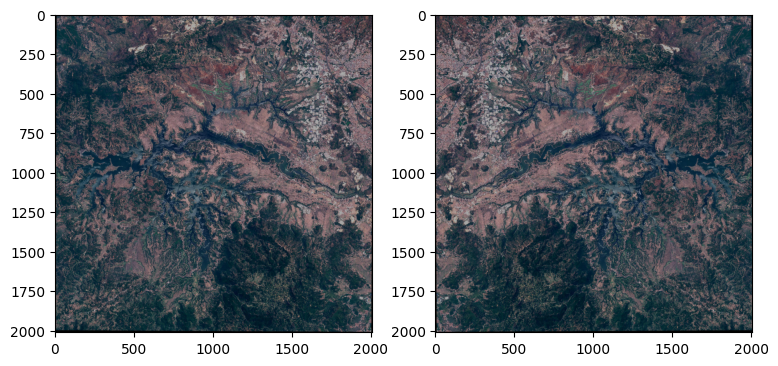

In [12]:
# Flip takes the probaility as param., so for every run, image may or may not get flipped
hor_flipper = v2.RandomHorizontalFlip(p=0.5)
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(Image.open(real_data[0]))
plt.subplot(1,2,2)
plt.imshow(hor_flipper(Image.open(real_data[0])))

### Test Random Rotation

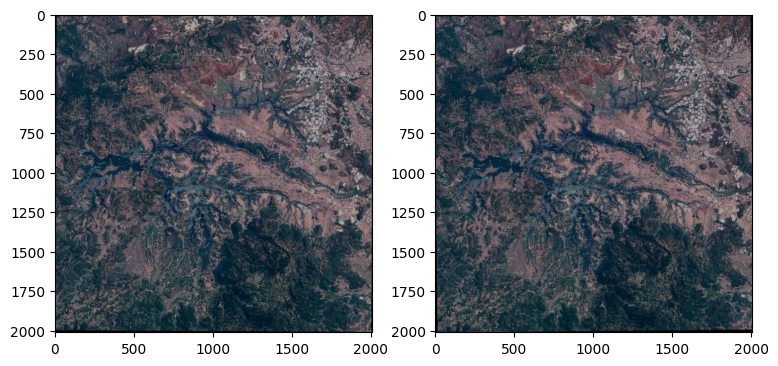

In [13]:
rot = v2.RandomRotation((0,30))
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(Image.open(real_data[0]))
plt.subplot(1,2,2)
plt.imshow(rot(Image.open(real_data[0])))

### Test Vertical Flip

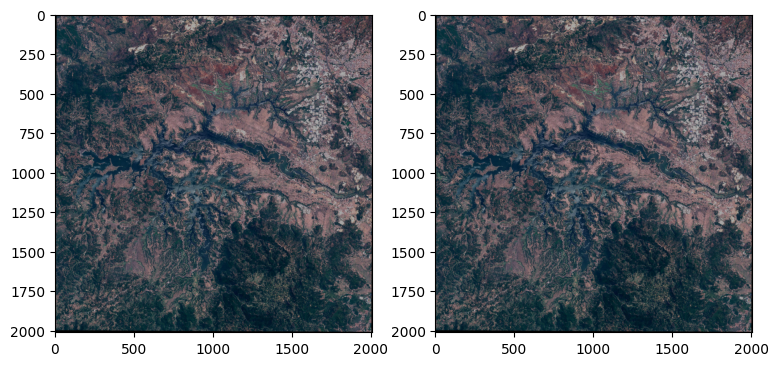

In [14]:
ver_flipper = v2.RandomVerticalFlip(p=0.1)
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(Image.open(real_data[0]))
plt.subplot(1,2,2)
plt.imshow(ver_flipper(Image.open(real_data[0])))

### Check color changes

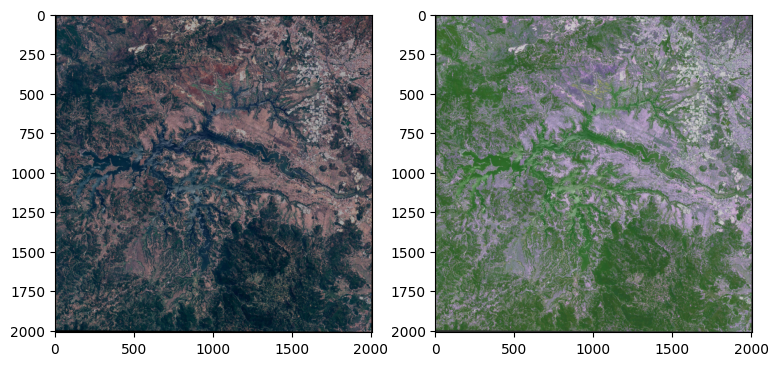

In [15]:
col_changer = v2.ColorJitter(brightness=1,contrast = 1, saturation = 0.3, hue = 0.5)
# contrast determines the no. of shades. saturation det. the intensity, hue should be less than 0.5
# hue shifts the color values
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(Image.open(real_data[0]))
plt.subplot(1,2,2)
plt.imshow(col_changer(Image.open(real_data[0])))

### Check greyscale transformation

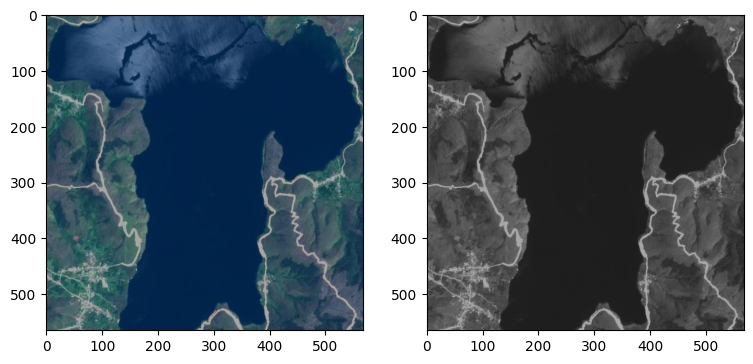

In [16]:
gray = v2.Grayscale(3)
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(Image.open(real_data[2]))
plt.subplot(1,2,2)
plt.imshow(gray(Image.open(real_data[2])))

In [17]:
print (asarray(Image.open(real_data[2])).shape)
print (asarray(gray(Image.open(real_data[2]))).shape)

(565, 568, 3)
(565, 568, 3)


### **Building the Model: U-Net on PyTorch**

### Dataset Preparation

In [18]:
class SatelliteData(Dataset):
  def __init__(self, real_data, masked_data, transform = None, mask_transform = None):
    super().__init__()

    self.real_data = real_data
    self.masked_data = masked_data

    self.transform = transform
    self.mask_transform = mask_transform

  def __len__(self):
    return len(self.real_data)

  # We locate the file, convert to tensor using read_image, call the transforms (if appl.) and return
  def __getitem__(self, index):
    image = read_image(self.real_data[index])
    if self.transform is not None:
      image = self.transform(image)
      image = image/250.0

    mask = read_image(self.masked_data[index])
    if self.mask_transform is not None:
      mask = self.transform(mask)
      mask = self.mask_transform(mask)
      mask = mask/255.0

    return image, mask

In [19]:
transform = v2.Compose([v2.Resize((SIZE,SIZE)),v2.RandomHorizontalFlip(),v2.RandomRotation((0,30)),
                        v2.RandomVerticalFlip(0.1)])

test_transform = v2.Compose([v2.Resize((SIZE,SIZE))])

mask_transform = v2.Grayscale(1)

Testing whether the dataset works or not

In [20]:
obj = SatelliteData(real_data, masked_data)
print (obj.masked_data[0:2], obj.masked_data[0:2])

['/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_1.jpg', '/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_10.jpg'] ['/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_1.jpg', '/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_10.jpg']


In [21]:
obj.transform, obj.mask_transform

(None, None)

In [22]:
# test the len func
len(obj)

2841

In [23]:
# test the getitem func
print (obj[0][0].shape, obj[0][1].shape)
obj[0][0].dtype

torch.Size([3, 2009, 2007]) torch.Size([3, 2009, 2007])


torch.uint8

In [24]:
# test the transformation
obj = SatelliteData(real_data, masked_data, transform, mask_transform)
print (obj.masked_data[0:2], obj.masked_data[0:2])
print (obj.transform, obj.mask_transform)

obj[0][0].shape, obj[0][1].shape

['/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_1.jpg', '/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_10.jpg'] ['/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_1.jpg', '/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/Water Bodies Dataset/Masks/water_body_10.jpg']
Compose(
      Resize(size=[128, 128], interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomHorizontalFlip(p=0.5)
      RandomRotation(degrees=[0.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
      RandomVerticalFlip(p=0.1)
) Grayscale(num_output_channels=1)


(torch.Size([3, 128, 128]), torch.Size([1, 128, 128]))

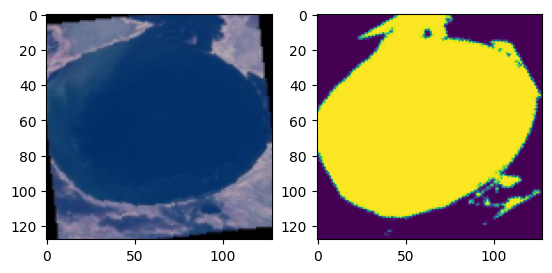

In [25]:
# matplotlib doesn't understand normalization of RGB images, so either convert them to int, or normalize again
plt.subplot(1,2,1)
plt.imshow(obj[12][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(obj[12][1].permute(1,2,0))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(real_data, masked_data, test_size=0.1, random_state=SEED)

In [27]:
train_data = SatelliteData(X_train, y_train, transform, mask_transform)
test_data = SatelliteData(X_test, y_test,test_transform,mask_transform)

In [28]:
# num_workers represents the no. of batches that will be parallelly loaded: Windows needs to have a main() imple.- Not exce. now
train_loader = DataLoader(train_data,batch_size=BATCH,shuffle=True)
test_loader = DataLoader(test_data,batch_size=BATCH, shuffle = False)

In [29]:
print (len(train_data), len(train_loader))
print (len(test_data), len(test_loader))

2556 80
285 9


torch.Size([32, 3, 128, 128]) torch.Size([3, 128, 128])


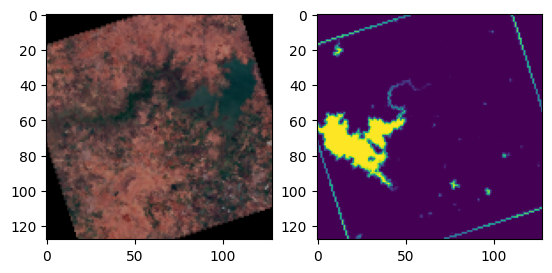

In [30]:
# test the train data loader
for i, (x,y) in enumerate(train_loader):
  print (x.shape, x[0].shape)
  plt.subplot(1,2,1)
  plt.imshow(x[1].permute(1,2,0))
  plt.subplot(1,2,2)
  plt.imshow(y[1].permute(1,2,0))
  break

torch.Size([32, 3, 128, 128]) torch.Size([3, 128, 128])


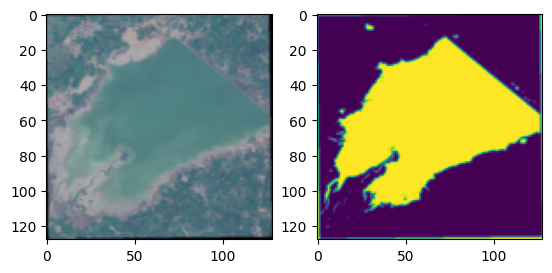

In [31]:
# test the val data loader
for i, (x,y) in enumerate(test_loader):
  print (x.shape, x[0].shape)
  plt.subplot(1,2,1)
  plt.imshow(x[1].permute(1,2,0))
  plt.subplot(1,2,2)
  plt.imshow(y[1].permute(1,2,0))
  break

### Defining the model for binary segmentation

Understanding UNet: Every pixel is broken into water or non-water class

In [32]:
class DoubleConv(nn.Module):

  def __init__(self,num_in_chan, num_out_chan):
    super().__init__()

    # same padding ensures that the size of o/p feature map is the same as i/p
    # batch_norm has its own bias paramater called the shift_param (alpha and beta)
    # The shift_params overwrite the Conv2D's bias, hence we remove the redundant bias
    self.conv_block = nn.Sequential(
    nn.Conv2d(num_in_chan,num_out_chan,padding='same',kernel_size=(3,3),bias= False),
    nn.BatchNorm2d(num_out_chan),
    nn.ReLU(inplace = True),

    nn.Conv2d(num_out_chan,num_out_chan,padding='same',kernel_size=(3,3),bias=False),
    nn.BatchNorm2d(num_out_chan),
    nn.ReLU(inplace = True))

  def forward(self,x):
      return self.conv_block(x)

In [33]:
# Create the Downsampling Block
class encoder(nn.Module):
  def __init__(self,num_in_chan,num_out_chan):
    super().__init__()
    self.conv_block = DoubleConv(num_in_chan,num_out_chan)
    self.pool = nn.MaxPool2d(2)

  def forward(self,x):
    side = self.conv_block(x)
    down = self.pool(side)
    return side,down

In [34]:
# Create the Upsampling Block
class decoder(nn.Module):
  def __init__(self,num_in_chan,num_out_chan):
    super().__init__()
    # stride = 2 in order to maintain the channel size to its corresponding conv2d layer
    # for ConvTranspose2d, padding should be an int/tuple and not string
    self.conv1 = nn.ConvTranspose2d(num_in_chan,num_out_chan,kernel_size=2,stride=2,padding=0)
    # no. of channels is twice to align with the channel dim. input = down + its corresponding conv2d side
    self.conv2 = DoubleConv(num_out_chan*2,num_out_chan)

  def forward(self,x,side):
    x = self.conv1(x)
    # The channels from side and down are concatenated. Shape is (Batch, Channel, Height, Width) hence dim=1
    x = torch.cat([x,side],dim=1)
    up = self.conv2(x)
    return up

In [35]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder1 = encoder(3,64)
    self.encoder2 = encoder(64,128)
    self.encoder3 = encoder(128,256)
    self.encoder4 = encoder(256,512)

    self.b1 = DoubleConv(512,1024)

    self.decoder1 = decoder(1024,512)
    self.decoder2 = decoder(512,256)
    self.decoder3 = decoder(256,128)
    self.decoder4 = decoder(128,64)

    # channels = 1 as this is a binary segmentation- water as the foreground vs. rem. as the background
    # for n classes, use channels = n
    self.output = nn.Conv2d(64,1,kernel_size=(1,1))

  def forward(self,x):
    self.encoder1.side1,self.encoder1.down1 = self.encoder1(x)
    self.encoder2.side2,self.encoder2.down2 = self.encoder2(self.encoder1.down1)
    self.encoder3.side3,self.encoder3.down3 = self.encoder3(self.encoder2.down2)
    self.encoder4.side4,self.encoder4.down4 = self.encoder4(self.encoder3.down3)

    # we don't call sigmoid here as we use the loss function BCEWithLogitsLoss()
    self.b1_out = self.b1(self.encoder4.down4)

    self.decoder1_out = self.decoder1(self.b1_out,self.encoder4.side4)
    self.decoder2_out = self.decoder2(self.decoder1_out,self.encoder3.side3)
    self.decoder3_out = self.decoder3(self.decoder2_out,self.encoder2.side2)
    self.decoder4_out = self.decoder4(self.decoder3_out,self.encoder1.side1)

    self.output_out = self.output(self.decoder4_out)
    return self.output_out

Test the Model's output shape

In [36]:
x = torch.randn((3,3,128,128))
x.shape, x[0][0]

(torch.Size([3, 3, 128, 128]),
 tensor([[ 0.2134, -1.3724, -0.5734,  ...,  0.2147,  0.1149, -1.9376],
         [-1.1926, -0.3832, -1.1616,  ...,  0.1384, -0.5832,  0.3602],
         [-0.3167, -1.5426, -0.6979,  ...,  0.2617,  0.8312, -1.7749],
         ...,
         [-1.6548,  0.7678,  0.5179,  ...,  0.2054,  0.4525,  1.7912],
         [-0.1789, -0.5979,  0.1379,  ...,  0.5683, -0.7171, -1.7035],
         [ 1.7356,  0.3473,  0.9361,  ..., -0.7122,  1.1752,  2.1633]]))

In [37]:
samp = UNet()

In [38]:
samp(x).shape, samp(x)[0][0]

(torch.Size([3, 1, 128, 128]),
 tensor([[ 0.2857,  0.6098,  0.4484,  ...,  0.4599,  0.3616,  0.6559],
         [ 0.2129,  0.5186,  0.3156,  ..., -0.0833, -0.2257, -0.0887],
         [-0.0516,  0.3931,  0.3674,  ...,  0.4493, -0.3456,  0.4636],
         ...,
         [ 0.3184,  0.3724,  0.3424,  ...,  0.4211, -0.3740,  0.1603],
         [-0.0369,  0.3257,  0.1080,  ...,  0.4801,  0.2268,  0.4374],
         [-0.0624,  0.4158, -0.0909,  ...,  0.0543,  0.3131,  0.1544]],
        grad_fn=<SelectBackward0>))

### Model Training and Evaluation

In [39]:
def train_model(train_loader,model,opt):
  epoch_loss = 0.0
  model.train()
  loop = tqdm(train_loader)
  for i, (X,y) in enumerate(loop):
    X = X.to(device)
    y = y.to(device)
    # X, y = X.float(), y.float() is not needed as they are already of float dtype
    y_pred = model(X)
    loss = criterion(y_pred,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    loop.set_postfix(loss = loss.item())
  return epoch_loss/len(train_loader)

In [40]:
# Testing the train model class
criterion = nn.BCEWithLogitsLoss()
model = UNet()
optimizer = torch.optim.Adam(model.parameters())
epoch_loss = 0.0
model.train()
loop = tqdm(train_loader)
for i, (X,y) in enumerate(loop):
  y_pred = model(X)
  print (f'Prediction is {y_pred} \n max is {torch.max(y_pred)}, min is {torch.min(y_pred)}')
  print (f'Actual is {y} \n max is {torch.max(y)}, min is {torch.min(y)}')

  loss = criterion(y_pred,y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  epoch_loss += loss.item()
  loop.set_postfix(loss = loss.item())
  if i==2:
    break

  0%|          | 0/80 [00:00<?, ?it/s]

Prediction is tensor([[[[ 0.7239,  0.6288,  1.0225,  ...,  1.1815,  1.1178,  0.7059],
          [-0.1304,  0.3519,  0.3381,  ...,  0.7724,  0.5162,  0.4277],
          [ 0.0939,  0.4435,  0.3667,  ...,  0.5944,  0.2803,  0.0840],
          ...,
          [ 0.0729,  0.1700,  0.3685,  ...,  0.3199, -0.0684,  0.4566],
          [-0.5872, -0.2032,  0.1508,  ...,  0.1617, -0.6688,  0.2456],
          [ 0.5641,  0.2160, -0.0821,  ...,  0.0331,  0.3244,  0.0268]]],


        [[[ 0.7095,  0.6260,  0.9713,  ...,  1.1648,  1.1608,  0.7364],
          [ 0.0317,  0.3073,  0.2055,  ...,  0.7708,  0.5063,  0.3933],
          [ 0.0764,  0.3620,  0.3352,  ...,  0.6044,  0.3504,  0.0754],
          ...,
          [ 0.0048,  0.2787,  0.2773,  ...,  0.4364,  0.0242,  0.5285],
          [-0.5199, -0.0624,  0.0401,  ...,  0.2284, -0.6587,  0.2680],
          [ 0.5026,  0.3010, -0.1097,  ...,  0.1080,  0.2656,  0.0601]]],


        [[[ 0.7590,  0.7604,  0.9432,  ...,  0.8671,  1.2456,  0.7515],
          [-

  1%|▏         | 1/80 [01:11<1:34:16, 71.60s/it, loss=0.75]

Prediction is tensor([[[[ 0.1551, -0.1963,  0.0589,  ..., -0.3823,  0.1952,  0.2572],
          [-0.5750, -1.3445, -1.5207,  ..., -0.9929, -1.4573, -0.3154],
          [-0.8139, -1.4939, -1.8033,  ..., -1.4636, -1.1720, -0.6694],
          ...,
          [-0.7985, -1.3775, -1.7875,  ..., -2.2223, -1.5227, -0.6497],
          [-1.2612, -1.3652, -1.3887,  ..., -1.3657, -1.1801, -0.5263],
          [-0.4348, -0.4800, -0.7427,  ..., -0.9403, -0.4534, -0.2991]]],


        [[[ 0.0187, -0.4821, -0.3619,  ...,  0.0287,  0.2899,  0.2414],
          [-0.6958, -1.1011, -1.0491,  ..., -0.6449, -1.1260, -0.2150],
          [-0.8581, -1.0739, -0.7540,  ..., -0.7086, -0.9508, -0.5534],
          ...,
          [-0.7822, -1.3943, -1.3792,  ..., -1.6203, -1.4163, -0.0066],
          [-1.1932, -1.0778, -0.3947,  ..., -1.4825, -0.9396, -0.2865],
          [-0.4835, -0.4532, -0.4128,  ..., -0.7904, -0.3950, -0.1996]]],


        [[[ 0.0919, -0.2363, -0.2384,  ..., -0.4154,  0.2312,  0.1984],
          [-

  2%|▎         | 2/80 [02:19<1:29:56, 69.18s/it, loss=0.735]

Prediction is tensor([[[[ 0.3452,  0.2196,  0.4128,  ..., -0.0232,  0.3925,  0.2961],
          [ 0.3001,  0.0070,  0.0566,  ..., -0.0772,  0.0544,  0.1767],
          [ 0.1876,  0.2026,  0.5437,  ...,  0.0158,  0.6634,  0.1677],
          ...,
          [ 0.2287,  0.4360,  0.1202,  ..., -0.0204,  0.4652,  0.1377],
          [-0.2547,  0.1261,  0.4324,  ...,  0.0762,  0.3866,  0.1177],
          [ 0.2130,  0.4460,  0.3033,  ...,  0.0502,  0.3590,  0.0244]]],


        [[[ 0.3448,  0.2360,  0.4065,  ..., -0.0217,  0.3879,  0.2966],
          [ 0.3017, -0.0147,  0.0560,  ..., -0.0820,  0.0429,  0.1710],
          [ 0.1398,  0.1858,  0.5214,  ...,  0.0163,  0.6549,  0.1685],
          ...,
          [ 0.2074,  0.4187,  0.1166,  ..., -0.0116,  0.4737,  0.1438],
          [-0.2542,  0.1218,  0.4154,  ...,  0.0650,  0.3868,  0.1138],
          [ 0.2004,  0.4492,  0.3020,  ...,  0.0518,  0.3501,  0.0260]]],


        [[[ 0.3408,  0.2289,  0.4121,  ..., -0.0223,  0.3928,  0.2960],
          [ 

  2%|▎         | 2/80 [03:25<2:13:37, 102.79s/it, loss=0.664]


***Loss was becoming negative for the first run***

**Reason**: BCEWithLogitsLoss(predictions, actuals) needs predictions and actuals to belong in the range (-inf, inf) and actuals in (0,1).  In my case, input y was not normalized, hence dividing value by 255.0 becomes important

In [41]:
def eval_model(test_loader,model):
  epoch_loss = 0.0
  model.eval()
  with torch.no_grad():
    loop = tqdm(test_loader)
    for i,(X,y) in enumerate(loop):
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)
      loss = criterion(y_pred,y)
      epoch_loss += loss.item()
      loop.set_postfix(loss = loss.item())
  return epoch_loss/len(test_loader)

### ToDo: About Dice Loss:

Dice coeff. = 2*Overlap between Pred versus actual/Area of Pred + Actual
Dice Loss = 1 - Dice Coeff.

Here, for every iteration, 2*overlap further decreases the loss compared to IoU, making it a better metric for obj. segmentation

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)
model = UNet()
model = model.to(device)

cpu


In [43]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

In [ ]:
# objective of loss function is not to minimize loss, but to bring it to 0
train, val, best_val_loss = [],[], float('inf')
for epoch in range(EPOCHS):
  train_loss = train_model(train_loader,model,optimizer)
  train.append(train_loss)
  val_loss = eval_model(test_loader,model)
  val.append(val_loss)

  if best_val_loss > val_loss:
    print (f'Best Validation loss is reduced from {best_val_loss} to {val_loss}')
    best_val_loss = val_loss
    torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/WaterBody_ImageSegmentation/BestModel.pt')

  print (f'For epoch no.{epoch}')
  print (f'Train loss:{train_loss}, Validation loss:{val_loss}')

  1%|▏         | 1/80 [01:06<1:28:03, 66.87s/it, loss=0.811]